In [1]:
import numpy as np

In [2]:
# Create data sets for comaprison
from ipynb.fs.defs.datasets import N_DIM, N_POINTS, default_sets

BLOCKS = [5, 5]
# BLOCKS = [1] * N_DIM
# BLOCKS = [10,]*3
# MINERvA
# BLOCKS = [54,] * 4

N_DIM = np.sum(BLOCKS)

datasets = default_sets(N_DIM, type="diagblock", blocks=BLOCKS)


# N_POINTS = 100000
# datasets = default_sets(N_DIM, type="diagblock", blocks=BLOCKS, remove={"Corr.50", "Corr.90"}, N_points=N_POINTS)

In [3]:
# Get distance function and expected distribution
from ipynb.fs.defs.covfit import Cee2, fitted
from scipy.stats import chi2

expected = Cee2(k=BLOCKS)
dist = lambda x: fitted(x, k=BLOCKS)
dname = "block-fitted"

In [4]:
# Compute distances
distances = {}
for name, data in datasets.items():
    distances[name] = dist(data)
    print(name, np.all(np.isfinite(distances[name])))

Uncorr. True
Corr.50 True
Corr.90 True
Corr.99 True


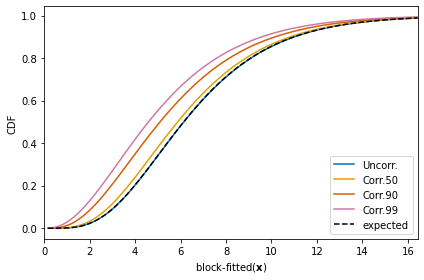

In [5]:
# Compare cumulative distributions
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
x = np.linspace(0, expected.mean() + expected.std() * 3, 100)
for name in datasets:
    tot = len(distances[name])
    count, bins = np.histogram(distances[name], bins=x)
    cdf = np.cumsum(count) / tot
    ax.plot(x[1:], cdf, label=name)
ax.plot(x[1:], expected.cdf(x[1:]), label=f"expected", linestyle="dashed")
ax.set_xlim(0, expected.mean() + expected.std() * 3)
ax.set_xlabel(f"{dname}$(\mathbf{{x}})$")
ax.set_ylabel("CDF")
ax.legend(loc="lower right")
fig.tight_layout()
fig.savefig(f"plots/{dname}_cdf.pdf")

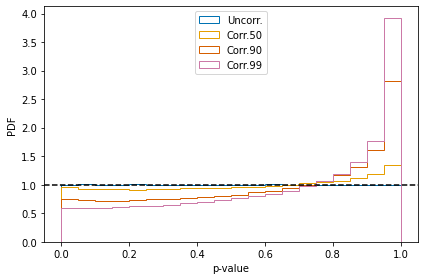

In [6]:
# Spread of p-values
fig, ax = plt.subplots()
x = np.linspace(0, 1, 21)
for name, data in distances.items():
    ax.hist(
        expected.sf(data),
        bins=x,
        histtype="step",
        density=True,
        cumulative=False,
        linestyle="solid",
        label=name,
    )
ax.axhline(1.0, color="k", linestyle="dashed")
# ax.set_yscale("log")
ax.set_xlabel("p-value")
ax.set_ylabel("PDF")
ax.legend(loc="upper center")
fig.tight_layout()
fig.savefig(f"plots/{dname}_p-values.pdf")

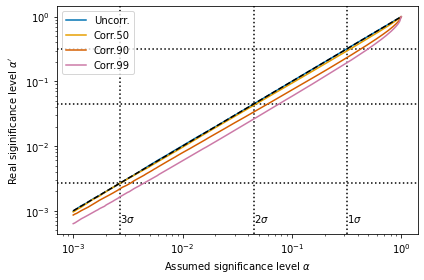

In [7]:
# siginifcance levels
fig, ax = plt.subplots()
for s in [1, 2, 3]:
    SL = chi2.sf(s**2, df=1)
    ax.axhline(SL, color="k", linestyle="dotted")
    ax.axvline(SL, color="k", linestyle="dotted")
    ax.annotate(f"${s}\sigma $ ", (SL, 0.05), xycoords=("data", "axes fraction"))

x = np.logspace(-3, 0, 200)
for name, data in distances.items():
    y = np.sum(data[:, np.newaxis] >= expected.isf(x), axis=0) / len(data)
    ax.plot(x, y, label=name)
ax.plot([1e-3, 1], [1e-3, 1], color="k", linestyle="dashed")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel(r"Real siginificance level $\alpha'$")
ax.set_xlabel(r"Assumed significance level $\alpha$")
ax.legend(loc="upper left")
fig.tight_layout()
fig.savefig(f"plots/{dname}_significance.pdf")

In [8]:
del distances
del data
del datasets